# Spectral fitting 
Demonstration of how to fit a spectrum for the example described in `response_demo.ipynb` where an instrument response was generated for a simple toy detector. We assume the simple case of no background.

We will look at two different methods for comparison, both written in [Stan](https://mc-stan.org).

In [1]:
import numpy as np
import h5py
import stan_utility
import corner
from matplotlib import pyplot as plt
from instrument_response.detector import Response

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
random_seed = 1

We have some data detected by our toy detector. We think it comes from a power law (this is our model), and under this assumption, we want to fit for the normalisation, $F_N$, and spectral index, $\alpha$, of this model (the parameters). In order to compare our model with data, we will use the response generated in `response_demo.ipynb`.

In [3]:
# Load response
response_file = 'output/response_sim.h5'
with h5py.File(response_file, 'r') as f:
    initial_energy = f['initial_energy'].value
    true_energy = f['true_energy'].value
    detected_energy = f['detected_energy'].value
    effective_area_max = f['effective_area_maximum'].value
response = Response(initial_energy, true_energy, detected_energy, effective_area_max, 
                    nbins_true_energy=50, nbins_detected_energy=50)

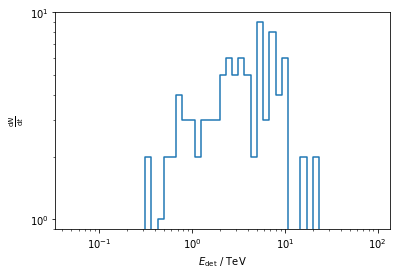

In [7]:
# Have a look at the data 
data_file = 'output/data.h5'

with h5py.File(data_file, 'r') as f:
    detected_energy = f['detected_energy'].value

dN_dt, _ = np.histogram(detected_energy, bins=response.detected_energy_bins)

fig, ax = plt.subplots()
ax.step(response.detected_energy_bins[:-1], dN_dt, where='pre')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_\mathrm{det}$ / TeV')
ax.set_ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}t}$');

## Standard approach
For this simple fitting example, we can fold our model spectrum through the instrument response to compare with the data in the fit, as described in `response_demo.ipynb`. We will use Hamiltonian Monte Carlo as implemented in `Stan` to determine which model parameters best describe our data.

The likelihood is
$$
p(n | \alpha, F_N) = \prod_{i=1}^{N_{\rm{bins}}} \frac{s_i^{n_i}e^{-s_i}}{n_i!},
$$

where $s_i$ are the expected counts in each energy bin (or *channel*), computed by folding the model through the repsonse, and $n_i$ are the actual observed counts in each energy bin.

In [8]:
# Compile the Stan model
model = stan_utility.compile_model(filename='stan/standard_approach.stan', 
                                   model_name='standard')

Using cached StanModel


In [9]:
# Run the fit
fit_input = {}
fit_input['Nbins_true'] = response.nbins_true_energy
fit_input['Nbins_detected'] = response.nbins_detected_energy
fit_input['min_energy'] = 1 # TeV
fit_input['max_energy'] = 100 # TeV
fit_input['n'] = dN_dt
fit_input['response_matrix'] = response.matrix
fit_input['true_energy_bins'] = response.true_energy_bins
fit_input['detected_energy_bins'] = response.detected_energy_bins

fit = model.sampling(data=fit_input, iter=1000, chains=4, seed=random_seed)
# Warnings below just because some channels have zero counts...

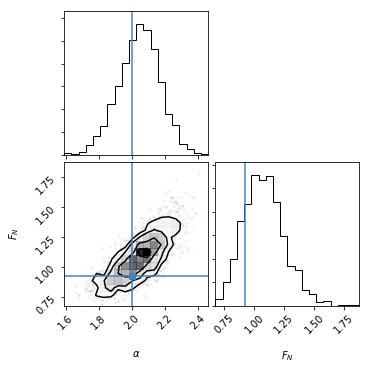

In [10]:
# View fit parameters
chain = fit.extract(permuted=True)
key_list = ['alpha', 'F_N']
labels = [r'$\alpha$', r'$F_N$']

# Compare with true values
with h5py.File(data_file, 'r') as f:
    true_alpha = f['power_law_index'].value
    true_F_N = f['flux_normalisation'].value
truths = [true_alpha, true_F_N]

corner.corner(np.column_stack([chain[key] for key in key_list]),
              labels=labels, truths=truths);

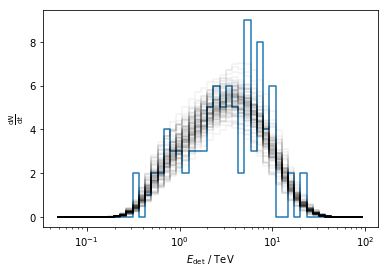

In [13]:
# Look at samples of folded model counts in data space
fig, ax = plt.subplots()
ax.step(response.detected_energy_bins[:-1], fit_input['n'], where='pre')
for i in range(100):
    ax.step(response.detected_energy_bins[:-1], chain['s'][i], 
            where='pre', color='k', alpha = 0.05)
ax.set_xscale('log')
ax.set_xlabel('$E_\mathrm{det}$ / TeV')
ax.set_ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}t}$');

## Hierarchical approach

Another way to think about this could be to model each particle/photon from production to detection. In this way, each particle/photon would have latent *true* energies inferred from their detected energies. 


This time, instead of the response matrix used above, we now want a related quantity, the probability distribution of $P(E_{\rm{det}} | E_{\rm{true}})$ which will form part of the hierarchical likelihood. Our data will also now be just the detected energies for each event registered in the detector. 

The likelihood is that of a poisson process which varies with energy
$$
P(E_{\rm{det}} | \alpha, N) = e^{-\bar{N}_{\rm{events}}}\prod_{i=1}^{N_{\rm{events}}} 
P({\rm{detected}} | E_{\rm{true}})P(E_{\rm{det}}^i | E_{\rm{true}}^i) P(E_{\rm{true}}^i | \alpha, N),
$$

where $\bar{N}_{\rm{events}} = \int {\rm{d}}E \ A_{\rm{eff}}(E) \frac{{\rm{d}}N}{{\rm{d}}E{\rm{d}}t{\rm{d}}A}$. We can get the conditional probability distribution $P(E_{\rm{det}} | E_{\rm{true}})$ and the effective area $A_{\rm{eff}}(E)$ from the same information used to construct the response matrix.

In [14]:
# Get the conditional log probability
true_energy_grid = np.logspace(np.log(1.0), np.log(100.0), 
                               response.nbins_true_energy, base=np.e)
cond_log_prob = response.get_log_conditionals(detected_energy, true_energy_grid)

In [15]:
# Compile the Stan model
model = stan_utility.compile_model(filename='stan/hierarchical_approach.stan', 
                                   model_name='hierarchical', include_paths='stan/')

Using cached StanModel


In [16]:
# Run the fit
fit_input = {}
fit_input['Nevents'] = len(detected_energy)
fit_input['Edet'] = detected_energy
fit_input['min_energy'] = 1.0 # TeV
fit_input['max_energy'] = 100.0 # TeV
fit_input['Ngrid'] = response.nbins_true_energy
fit_input['Etrue_grid'] = true_energy_grid
fit_input['cond_log_prob'] = cond_log_prob

fit = model.sampling(data=fit_input, iter=1000, chains=4)

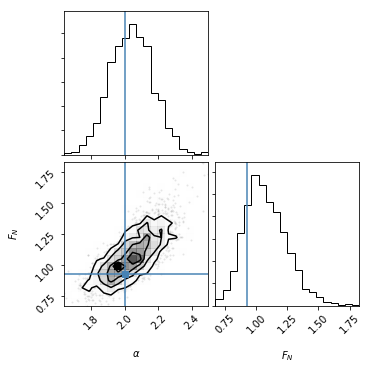

In [17]:
# View fit parameters
chain = fit.extract(permuted=True)
key_list = ['alpha', 'F_N']
labels = [r'$\alpha$', '$F_N$']

# Compare with true values
with h5py.File(data_file, 'r') as f:
    true_alpha = f['power_law_index'].value
    true_F_N = f['flux_normalisation'].value
truths = [true_alpha, true_F_N]

corner.corner(np.column_stack([chain[key] for key in key_list]),
              labels=labels, truths=truths);

We see similar results to the standard method, and for this simple problem, the fit is actually much faster in this form.

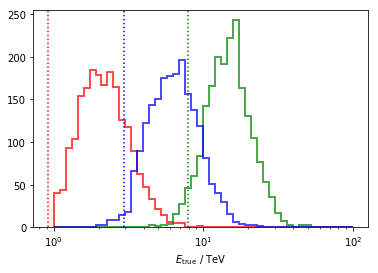

In [18]:
# Look at the latent energy samples
fig, ax = plt.subplots()

# Pick out 3 randomly 
for i, c in zip([0, 15, 24], ['r', 'g', 'b']):
    ax.hist(chain['Etrue'].T[i], bins=response.true_energy_bins,
            histtype='step', alpha = 0.7, lw=2, color=c);
    ax.axvline(detected_energy[i], linestyle=':', color=c)
ax.set_xscale('log')
ax.set_xlabel('$E_\mathrm{true}$ / TeV');

For each detected energy, the inferred latent true energies have a distribution, matching that described by the instrument response. Here the detected energy is also marked on the same axis as a dotted line. This concept is different to that of direct *inversion* or calculation of the true energies from the detected energies.

# Summary

The problem of fitting a spectrum from counts in a detector can be approached in two ways, by considering the number of counts in energy bins, or the energies of individual photons/particles. In both cases, we need to define some kind of description of the detection effects (response matrix, or effective area and energy dispersion separately) from a simulation of the detector. The nature of the detection process is probabilistic and as such, the detected energies cannot simply be inverted to deduce the spectral shape.